In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree

from xgboost import XGBRegressor

from sklearn import set_config
set_config(display = 'diagram')

# Sklearn preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, VarianceThreshold, SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [2]:
users_df = pd.read_csv('../raw_data/users.csv')
centers_df = pd.read_csv('../raw_data/distribution_centers.csv')
events_df = pd.read_csv('../raw_data/events.csv')
inventory_items_df = pd.read_csv('../raw_data/inventory_items.csv')
order_items_df = pd.read_csv('../raw_data/order_items.csv')
orders_df = pd.read_csv('../raw_data/orders.csv')
products_df = pd.read_csv('../raw_data/products.csv')

In [36]:
users_df_test = users_df.copy()

In [40]:
users_df_test['created_at'] = pd.to_datetime(users_df_test['created_at'],format='mixed').dt.tz_localize(None)

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

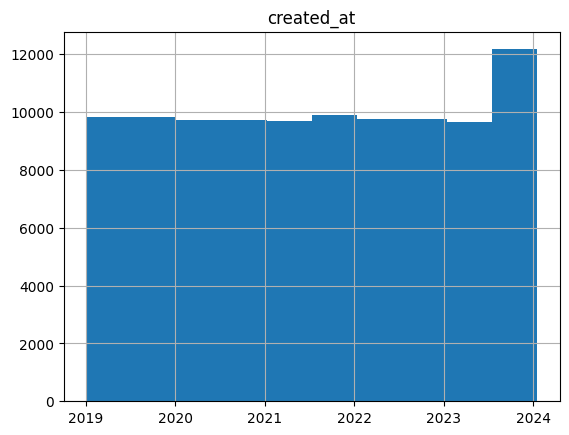

In [41]:
users_df_test.hist('created_at')

In [42]:
orders_test = orders_df.copy()

In [43]:
orders_test['created_at'] = pd.to_datetime(orders_test['created_at'],format='mixed').dt.tz_localize(None)

array([[<Axes: title={'center': 'created_at'}>]], dtype=object)

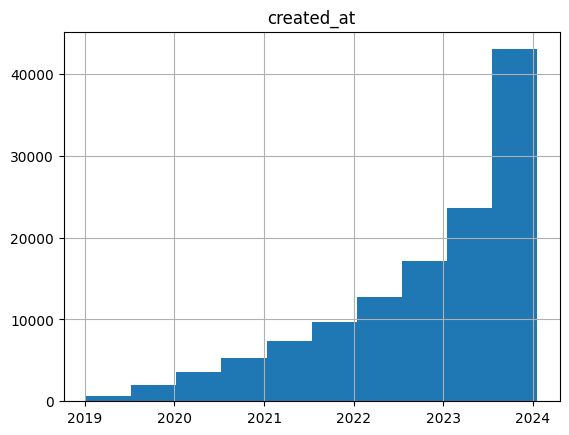

In [44]:
orders_test.hist('created_at')

In [3]:
def data_cleaning(order_items_df, orders_df):
    '''
    This function takes the order_items and the orders tables, aggregates the order_items table,
    merges the tables, cleans the datatypes and returns the cleaned dataframe
    '''

    # Agreegate the sale_price by order_id and merge the orders table
    order_sales = order_items_df[['order_id','sale_price']].groupby(by='order_id').sum('sale_price').reset_index()

    cleaned_order_sales = orders_df.merge(order_sales, on='order_id', how='left')

    # Convert the created_at column from 'object' to datetime64
    cleaned_order_sales['created_at'] = pd.to_datetime(cleaned_order_sales['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['returned_at'] = pd.to_datetime(cleaned_order_sales['returned_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['shipped_at'] = pd.to_datetime(cleaned_order_sales['shipped_at'],
                                                       format='mixed').dt.tz_localize(None)
    cleaned_order_sales['delivered_at'] = pd.to_datetime(cleaned_order_sales['delivered_at'],
                                                       format='mixed').dt.tz_localize(None)


    return cleaned_order_sales

In [46]:
def order_features(orders_df, order_items_df, split_date):
    '''
    Calculates features required for XBG
    inputs order_df, order_items_df, products_df
    Assumes revenue per order is already calculated in sale_price column,
    all the datetime fields and split_date should be in datetime format
    '''

    orders_df = data_cleaning(order_items_df, orders_df)

    # Days calculation
    orders_df['days_to_split_date'] = (split_date - orders_df['created_at']).dt.days
    orders_df['days_delivery'] = (orders_df['delivered_at'] - orders_df['created_at']).dt.days

    # Filter data only for last 2 years
    orders_df = orders_df[(orders_df.days_to_split_date >= 0) & (orders_df.days_to_split_date < 365*3)]

    # Base dataset : user level
    base = orders_df[['user_id','order_id']].groupby('user_id').count().rename(columns={'order_id': 'orders_total'})

    # Calculate first purchase, latest purchase
    first_purchase = orders_df[['user_id','created_at']].groupby('user_id').min().rename(columns={'created_at': 'min_created_at'})
    base = base.merge(first_purchase, on='user_id')
    latest_purchase = orders_df[['user_id','created_at']].groupby('user_id').max().rename(columns={'created_at': 'max_created_at'})
    base = base.merge(latest_purchase, on='user_id')


    # Days from first/last order (Recency, customer T)
    base['days_from_first_order'] =  (split_date - base['min_created_at']).dt.days
    base['days_from_last_order'] =  (split_date - base['max_created_at']).dt.days


    # Frequency, Monetary
    df_30 = orders_df[orders_df.days_to_split_date < 30]
    df_60 = orders_df[(orders_df.days_to_split_date >= 30) & (orders_df.days_to_split_date < 60)]
    df_120 = orders_df[(orders_df.days_to_split_date >= 60) & (orders_df.days_to_split_date < 120)]
    df_240 = orders_df[(orders_df.days_to_split_date >= 120) & (orders_df.days_to_split_date < 240)]
    df_480 = orders_df[(orders_df.days_to_split_date >= 240) & (orders_df.days_to_split_date < 480)]

    # orders per different timeframe
    f_30 = df_30[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_30d'})
    f_60 = df_60[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_60d'})
    f_120 = df_120[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_120d'})
    f_240 = df_240[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_240d'})
    f_480 = df_480[['user_id','order_id']].groupby(by='user_id').count().fillna(0).rename(columns={'order_id': 'orders_480d'})

    # Frequency Joined to base dataset
    base = base.merge(f_30,on='user_id',how='left')
    base = base.merge(f_60,on='user_id',how='left')
    base = base.merge(f_120,on='user_id',how='left')
    base = base.merge(f_240,on='user_id',how='left')
    base = base.merge(f_480,on='user_id',how='left')

    # orders per different timeframe
    m_30 = df_30[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_30d'})
    m_60 = df_60[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_60d'})
    m_120 = df_120[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_120d'})
    m_240 = df_240[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_240d'})
    m_480 = df_480[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_480d'})
    m_total = orders_df[['user_id','sale_price']].groupby(by='user_id').sum().fillna(0).rename(columns={'sale_price': 'revenue_total'})

    # Monetary Joined to base dataset
    base = base.merge(m_30,on='user_id',how='left')
    base = base.merge(m_60,on='user_id',how='left')
    base = base.merge(m_120,on='user_id',how='left')
    base = base.merge(m_240,on='user_id',how='left')
    base = base.merge(m_480,on='user_id',how='left')
    base = base.merge(m_total,on='user_id',how='left')

    # ABV calculation
    base['abv'] = base['revenue_total']/base['orders_total']

    # Other calcs (delivery, num_items)
    avg_delivery_days = orders_df[['user_id','days_delivery']].groupby('user_id').mean().rename(columns={'days_delivery': 'avg_delivery_days'})
    base = base.merge(avg_delivery_days, on='user_id')
    avg_items_p_order = orders_df[['user_id','num_of_item']].groupby('user_id').mean().rename(columns={'num_of_item': 'avg_num_items'})
    base = base.merge(avg_items_p_order, on='user_id')

    # Fill NA with 0 for selected columns
    selected_columns = ['orders_total',
              'orders_30d',
              'orders_60d',
              'orders_120d',
              'orders_240d',
              'orders_480d',
              'revenue_30d',
              'revenue_60d',
              'revenue_120d',
              'revenue_240d',
              'revenue_480d']

    base[selected_columns] = base[selected_columns].fillna(0)

    return base

In [55]:
temp_date = dt.datetime(2024,1,1)
result = order_features(orders_df, order_items_df, temp_date)
result.head(10)

,orders_total,min_created_at,max_created_at,days_from_first_order,days_from_last_order,orders_30d,orders_60d,orders_120d,orders_240d,orders_480d,revenue_30d,revenue_60d,revenue_120d,revenue_240d,revenue_480d,revenue_total,abv,avg_delivery_days,avg_num_items
user_id,,,,,,,,,,,,,,,,,,,
1,1,2022-07-18 12:55:00,2022-07-18 12:55:00,531,531,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,159.990000,159.990000,NaN,3.00
2,1,2022-02-20 10:34:00,2022-02-20 10:34:00,679,679,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,22.000000,22.000000,3.0,1.00
3,4,2023-03-10 09:13:00,2023-08-08 09:13:00,296,145,0.0,0.0,0.0,1.0,3.0,0.0,0.000000,0.0,108.750000,293.450001,402.200001,100.550000,3.0,1.25
4,1,2022-10-18 09:31:00,2022-10-18 09:31:00,439,439,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,148.000000,148.000000,148.000000,2.0,1.00
5,1,2022-10-20 10:03:00,2022-10-20 10:03:00,437,437,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,65.650000,65.650000,65.650000,NaN,3.00
6,1,2022-04-08 04:38:00,2022-04-08 04:38:00,632,632,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,144.820004,144.820004,NaN,2.00
7,1,2022-02-26 16:52:00,2022-02-26 16:52:00,673,673,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,84.209999,84.209999,NaN,1.00
8,1,2021-07-15 17:15:00,2021-07-15 17:15:00,899,899,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,80.689999,80.689999,NaN,2.00
9,1,2023-11-02 17:44:00,2023-11-02 17:44:00,59,59,0.0,1.0,0.0,0.0,0.0,0.0,71.950001,0.0,0.000000,0.000000,71.950001,71.950001,NaN,2.00


array([[<Axes: title={'center': 'orders_total'}>]], dtype=object)

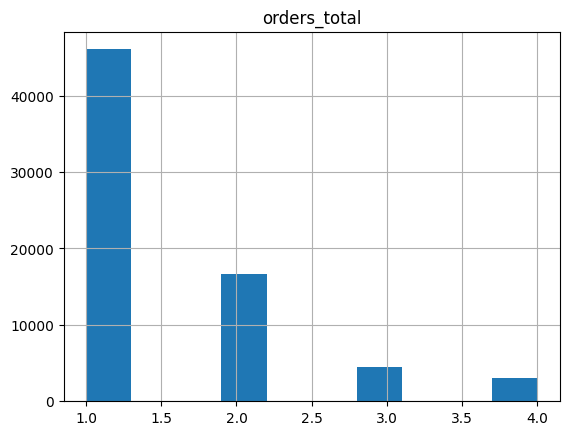

In [54]:
result.hist('orders_total')

In [15]:
products_df.columns

Index(['id', 'cost', 'category', 'name', 'brand', 'retail_price', 'department',
       'sku', 'distribution_center_id'],
      dtype='object')

In [59]:
orders_df[orders_df['num_of_item']>3].head()

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
36,462,382,Cancelled,F,2021-12-24 14:13:00+00:00,NaN,NaN,NaN,4
47,619,503,Cancelled,F,2023-08-31 00:41:00+00:00,NaN,NaN,NaN,4
61,809,647,Cancelled,F,2022-09-25 04:31:00+00:00,NaN,NaN,NaN,4
63,838,670,Cancelled,F,2023-12-06 17:11:00+00:00,NaN,NaN,NaN,4
74,956,767,Cancelled,F,2023-01-21 16:07:00+00:00,NaN,NaN,NaN,4


In [61]:
order_items_df[order_items_df['order_id']==462]

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
48103,683,462,382,9577,1878,Cancelled,2021-12-24 13:13:12+00:00,NaN,NaN,NaN,25.0
121267,685,462,382,139,1886,Cancelled,2021-12-24 10:49:01+00:00,NaN,NaN,NaN,58.0
139257,684,462,382,5723,1882,Cancelled,2021-12-24 12:42:48+00:00,NaN,NaN,NaN,74.0
173501,686,462,382,4638,1888,Cancelled,2021-12-28 12:05:41+00:00,NaN,NaN,NaN,179.0


In [63]:
products_df[products_df['id'].isin([9577,139,5723,4638])]

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
7055,9577,14.700,Sleep & Lounge,Cinema Etoile Women's Mix N' Match Three Piece...,Cinema Etoile,25.0,Women,08AE6A26B7CB089EA588E94AED36BD15,2
17932,4638,98.808,Jeans,Joe's Jeans Women's Stretch Denim Skinny Jeans,Joe's Jeans,179.0,Women,F08B7AC8AA30A2A9AB34394E200E1A71,6
20479,139,31.552,Tops & Tees,allen allen Women's Rugby Stripe Long Sleeve T...,Allen Allen,58.0,Women,E00DA03B685A0DD18FB6A08AF0923DE0,7
23645,5723,40.848,Leggings,American Apparel Riding Pant,American Apparel,74.0,Women,D94FD74DCDE1AA553BE72C1006578B23,8


In [16]:
def join_tables_item_level(order_items_df, products_df):
    '''
    Joins order-item & product
    '''
    order_items_df = order_items_df[['id', 
                                     'order_id', 
                                     'user_id', 
                                     'product_id', 
                                     'inventory_item_id',
                                     # 'status', 
                                     'created_at', 
                                     # 'shipped_at', 
                                     # 'delivered_at', 
                                     # 'returned_at',
                                     'sale_price']].rename(columns={'id':'order_item_id'})

    order_items_df['created_at'] = pd.to_datetime(order_items_df['created_at'],
                                                       format='mixed').dt.tz_localize(None)
    products_df = products_df[['id', 
                               'cost', 
                               'category', 
                               'name',
                               'brand',
                               'retail_price', 
                               # 'department',
                               # 'sku',
                               'distribution_center_id']]

    
    df_joined = order_items_df.merge(products_df, left_on='product_id', right_on='id', how='left')
    df_joined = df_joined.drop(columns=['id']) # duplicate product id    

    return df_joined

In [64]:
item_level_df = join_tables_item_level(order_items_df, products_df)

In [65]:
item_level_df[item_level_df['order_id']==462]

,order_item_id,order_id,user_id,product_id,inventory_item_id,created_at,sale_price,cost,category,name,brand,retail_price,distribution_center_id
48103,683,462,382,9577,1878,2021-12-24 13:13:12,25.0,14.700,Sleep & Lounge,Cinema Etoile Women's Mix N' Match Three Piece...,Cinema Etoile,25.0,2
121267,685,462,382,139,1886,2021-12-24 10:49:01,58.0,31.552,Tops & Tees,allen allen Women's Rugby Stripe Long Sleeve T...,Allen Allen,58.0,7
139257,684,462,382,5723,1882,2021-12-24 12:42:48,74.0,40.848,Leggings,American Apparel Riding Pant,American Apparel,74.0,8
173501,686,462,382,4638,1888,2021-12-28 12:05:41,179.0,98.808,Jeans,Joe's Jeans Women's Stretch Denim Skinny Jeans,Joe's Jeans,179.0,6


In [68]:
item_level_df[['category']].value_counts()

category                     
Intimates                        13474
Jeans                            12698
Tops & Tees                      11925
Fashion Hoodies & Sweatshirts    11885
Swim                             11428
Sweaters                         11265
Shorts                           11038
Sleep & Lounge                   11002
Accessories                       9753
Active                            9086
Outerwear & Coats                 8968
Underwear                         7527
Pants                             7328
Socks                             6346
Dresses                           5456
Suits & Sport Coats               5223
Maternity                         5165
Plus                              4323
Socks & Hosiery                   3787
Pants & Capris                    3389
Blazers & Jackets                 3205
Leggings                          3183
Skirts                            2134
Suits                             1024
Jumpsuits & Rompers               

In [18]:
item_level_df.head(20)

,order_item_id,order_id,user_id,product_id,inventory_item_id,created_at,sale_price,cost,category,name,brand,retail_price,distribution_center_id
0,152013,104663,83582,14235,410368,2023-05-07 06:08:40,0.02,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,1
1,40993,28204,22551,14235,110590,2023-03-14 03:47:21,0.02,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,1
2,51224,35223,28215,14235,138236,2023-12-05 13:25:30,0.02,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,1
3,36717,25278,20165,14235,99072,2023-12-22 20:48:19,0.02,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,1
4,131061,90241,71954,14235,353798,2022-06-19 16:57:59,0.02,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,1
5,154022,106052,84693,14235,415780,2023-09-19 09:13:08,0.02,0.00830,Accessories,Indestructable Aluminum Aluma Wallet - RED,marshal,0.02,1
6,67253,46269,37023,14159,181497,2021-10-31 01:26:46,0.49,0.17738,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.49,1
7,116116,80002,63821,14159,313368,2022-04-01 13:25:52,0.49,0.17738,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.49,1
8,28239,19512,15553,14159,76146,2023-10-29 08:08:40,0.49,0.17738,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.49,1
9,69641,47894,38312,14159,187914,2024-01-07 23:06:39,0.49,0.17738,Accessories,Set of 2 - Replacement Insert For Checkbook Wa...,Made in USA,0.49,1


In [ ]:
item_level_df[['user_id','brand','sale_price']].groupby(by=['user_id','brand']).sum()

In [79]:
test = item_level_df.groupby(['user_id', 'brand']).size().reset_index(name='count')

# Get index of most frequently bought brand for each user
idx = test.groupby(['user_id'])['count'].transform('max') == test['count']
most_frequent_brand_per_user = test[idx]

most_frequent_brand_per_user

,user_id,brand,count
0,1,Joe's Jeans,1
1,1,Tommy Hilfiger,1
2,1,eVogues Apparel,1
3,2,Tommy Bahama,1
4,3,Dockers,1
...,...,...,...
180438,99998,Woolrich,1
180439,99999,Hanes,1
180440,99999,Wrangler,1
180441,100000,Jockey,1


In [93]:
def calc_product_features(item_level_df, split_date):
    '''
    takes item-level dataframe and calculate features to user level.
    '''

    # filter data only for last 2 years
    min_date = split_date - pd.DateOffset(days=365*3)
    item_level_df = item_level_df[(item_level_df['created_at'] <= split_date) & (item_level_df['created_at'] > min_date)].copy()
    
    # Calculate the first orders
    item_level_df['order_rank'] = item_level_df.groupby('user_id')['created_at'].rank().astype(int) # calculating the order of orders
    item_level_df['order_rank_desc'] = item_level_df.groupby('user_id')['created_at'].rank(method='max').astype(int) # calculating the order of orders

    base = item_level_df[['user_id','order_item_id']].groupby('user_id').count().fillna(0).rename(columns={'order_item_id':'num_order_item'})
    
    # # taking value for the very first order
    # intial_values = item_level_df[item_level_df['order_rank']==1][['user_id','category','brand']].rename(columns={'category':'categ_initial',
    #                                                                                                               'brand':'brand_initial'})
    # base = base.merge(intial_values, on='user_id', how='left')

    # # taking value for the very last order
    # last_values = item_level_df[item_level_df['order_rank_desc']==1][['user_id','category','brand']].rename(columns={'category':'categ_last',
    #                                                                                                               'brand':'brand_last'})
    # base = base.merge(last_values, on='user_id', how='left')

    # item_level_df = item_level_df.rename(columns={'created_at':'order_item_created_at'})

    # Most frequent brand
    count_brands = item_level_df.groupby(['user_id', 'brand']).size().reset_index(name='count')
    idx = count_brands.groupby(['user_id'])['count'].transform('max') == count_brands['count']
    preffered_brand = count_brands[idx].drop(columns='count').rename(columns={'brand':'brand_preffered'})

    base = base.merge(preffered_brand, on='user_id', how='left')

    # Most frequent category
    count_cat = item_level_df.groupby(['user_id', 'category']).size().reset_index(name='count')
    idx = count_cat.groupby(['user_id'])['count'].transform('max') == count_cat['count']
    preffered_cat = count_cat[idx].drop(columns='count').rename(columns={'category':'category_preffered'})

    base = base.merge(preffered_cat, on='user_id', how='left')

    return base

In [91]:
item_level_df.columns

Index(['order_item_id', 'order_id', 'user_id', 'product_id',
       'inventory_item_id', 'created_at', 'sale_price', 'cost', 'category',
       'name', 'brand', 'retail_price', 'distribution_center_id'],
      dtype='object')

In [94]:
calc_product_features(item_level_df, temp_date).head()

,user_id,num_order_item,brand_preffered,category_preffered
0,1,3,Joe's Jeans,Active
1,1,3,Joe's Jeans,Blazers & Jackets
2,1,3,Joe's Jeans,Jeans
3,1,3,Tommy Hilfiger,Active
4,1,3,Tommy Hilfiger,Blazers & Jackets


In [95]:
def select_user_columns(users_df, split_date):

    df = users_df[['id','age','country','created_at']].rename(columns={'id':'user_id','created_at':'user_created_at'})
    # Filter users only for last 2 years from split date
    # min_date = split_date - pd.DateOffset(days=365*5)
    df['user_created_at'] = pd.to_datetime(df['user_created_at'], format='mixed').dt.tz_localize(None)
    df = df[(df['user_created_at'] <= split_date)]
    
    return df

In [ ]:
item_level_df.columns

In [96]:
def create_y_actual(order_items_df, split_date):
    df = order_items_df[['id','user_id','created_at','sale_price']].copy().rename(columns={'id':'order_item_id'})
    df['order_created_at'] = pd.to_datetime(df['created_at'], format='mixed').dt.tz_localize(None)

    # select next 90 days of revenue from split_date
    max_date = split_date + pd.DateOffset(days=90)
    df = df[(df['order_created_at'] <= max_date) & (df['order_created_at'] > split_date)]
    
    df_agg = df[['user_id','sale_price']].groupby('user_id').sum().fillna(0).rename(columns={'sale_price':'revenue_next_90d'})

    return df_agg

In [49]:
# Setting test dataset

test_date = dt.datetime(2024,1,1)
item_level_df = join_tables_item_level(order_items_df, products_df)

In [97]:
df_user = select_user_columns(users_df, test_date)
df_order = order_features(orders_df, order_items_df, test_date)
df_item = calc_product_features(item_level_df, test_date)
df_y_actual = create_y_actual(order_items_df, test_date)

In [ ]:
df_item.columns

In [98]:
def prep_input_dataset(df_user, df_order, df_item, df_y_actual):
    '''
    joins all preprocessed user-level-df
    '''
    
    final_df = df_user.merge(df_order, on='user_id', how='left')
    final_df = final_df.merge(df_item, on='user_id', how='left')
    final_df = final_df.merge(df_y_actual, on='user_id', how='left')

    final_df = final_df[final_df['orders_total']>0].copy()

    final_df = final_df.reset_index()

    return final_df


In [99]:
input_dataset = prep_input_dataset(df_user, df_order, df_item, df_y_actual)
input_dataset.columns

Index(['index', 'user_id', 'age', 'country', 'user_created_at', 'orders_total',
       'min_created_at', 'max_created_at', 'days_from_first_order',
       'days_from_last_order', 'orders_30d', 'orders_60d', 'orders_120d',
       'orders_240d', 'orders_480d', 'revenue_30d', 'revenue_60d',
       'revenue_120d', 'revenue_240d', 'revenue_480d', 'revenue_total', 'abv',
       'avg_delivery_days', 'avg_num_items', 'num_order_item',
       'brand_preffered', 'category_preffered', 'revenue_next_90d'],
      dtype='object')

In [71]:
input_dataset[['user_id','user_created_at','orders_total','days_from_first_order','revenue_total','abv', 'revenue_next_90d']].head(20)

,user_id,user_created_at,orders_total,days_from_first_order,revenue_total,abv,revenue_next_90d
0,457,2022-07-19 13:51:00,1.0,84.0,99.989998,99.989998,NaN
1,36280,2019-08-24 06:10:00,1.0,1074.0,72.120001,72.120001,NaN
2,60193,2020-02-15 11:26:00,1.0,1015.0,24.000000,24.000000,NaN
3,64231,2020-03-13 06:45:00,1.0,279.0,39.950001,39.950001,NaN
4,72187,2022-05-27 14:53:00,1.0,87.0,21.000000,21.000000,NaN
5,22528,2019-03-21 10:58:00,1.0,553.0,88.380001,88.380001,NaN
6,63352,2023-10-29 12:33:00,2.0,53.0,287.500000,143.750000,NaN
7,71901,2019-03-17 16:07:00,1.0,818.0,99.989998,99.989998,NaN
8,85095,2019-03-24 16:06:00,1.0,919.0,45.770000,45.770000,NaN
9,88385,2019-09-23 15:25:00,1.0,1025.0,149.000000,149.000000,NaN


In [ ]:
input_dataset.dtypes

In [100]:
used_columns = [
    'user_id',
    'age',
    'country',
    'orders_total',
    'days_from_first_order',
    'days_from_last_order',
    'orders_30d',
    'orders_60d',
    'orders_120d',
    'orders_240d',
    'orders_480d',
    'revenue_30d',
    'revenue_60d',
    'revenue_120d',
    'revenue_240d',
    'revenue_480d',
    'revenue_total',
    'abv',
    'avg_delivery_days',
    'avg_num_items',
    'num_order_item',
    'brand_preffered', 
    'category_preffered',
    'revenue_next_90d'
    ]

In [101]:
X = input_dataset[used_columns].drop(columns=['revenue_next_90d']).copy()
y = input_dataset[['user_id','revenue_next_90d']].copy()

In [102]:
X.head(10)

,user_id,age,country,orders_total,days_from_first_order,days_from_last_order,orders_30d,orders_60d,orders_120d,orders_240d,...,revenue_120d,revenue_240d,revenue_480d,revenue_total,abv,avg_delivery_days,avg_num_items,num_order_item,brand_preffered,category_preffered
0,457,65,Brasil,1.0,84.0,84.0,0.0,0.0,1.0,0.0,...,99.989998,0.0,0.000000,99.989998,99.989998,NaN,1.0,1.0,Haggar,Suits & Sport Coats
1,36280,13,Brasil,1.0,1074.0,1074.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,72.120001,72.120001,NaN,2.0,2.0,Hurley,Shorts
2,36280,13,Brasil,1.0,1074.0,1074.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,72.120001,72.120001,NaN,2.0,2.0,Hurley,Sleep & Lounge
3,36280,13,Brasil,1.0,1074.0,1074.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,72.120001,72.120001,NaN,2.0,2.0,Private Label,Shorts
4,36280,13,Brasil,1.0,1074.0,1074.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,72.120001,72.120001,NaN,2.0,2.0,Private Label,Sleep & Lounge
5,60193,64,Brasil,1.0,1015.0,1015.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,24.000000,24.000000,6.0,1.0,1.0,SmartWool,Socks
6,64231,25,Brasil,1.0,279.0,279.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,39.950001,39.950001,39.950001,2.0,1.0,1.0,2b by bebe,Pants & Capris
7,72187,47,Brasil,1.0,87.0,87.0,0.0,0.0,1.0,0.0,...,21.000000,0.0,0.000000,21.000000,21.000000,1.0,1.0,1.0,Pistil,Plus
8,22528,64,Brasil,1.0,553.0,553.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,88.380001,88.380001,NaN,2.0,2.0,Fox,Fashion Hoodies & Sweatshirts
9,22528,64,Brasil,1.0,553.0,553.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,88.380001,88.380001,NaN,2.0,2.0,Fox,Sleep & Lounge


In [110]:
num_columns = [
    # 'user_id',
    'age',
    # 'country',
    'orders_total',
    'days_from_first_order',
    'days_from_last_order',
    'orders_30d',
    'orders_60d',
    'orders_120d',
    'orders_240d',
    'orders_480d',
    'revenue_30d',
    'revenue_60d',
    'revenue_120d',
    'revenue_240d',
    'revenue_480d',
    'revenue_total',
    'abv',
    # 'avg_delivery_days',
    'avg_num_items',
    'num_order_item'
    # 'brand_preffered', 
    # 'category_preffered',
    ]

In [114]:
X_numeric = X[num_columns]

In [113]:
imputer = SimpleImputer(strategy='mean')

In [115]:
imputer.fit(X_numeric)

SimpleImputer()

In [116]:
imputed_X_num = imputer.transform(X_numeric)

In [141]:
scaler = MinMaxScaler()

In [142]:
scaler.fit(imputed_X_num)

MinMaxScaler()

In [143]:
X_scaled = scaler.transform(imputed_X_num)

In [144]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)
X_scaled_df.head()

,age,orders_total,days_from_first_order,days_from_last_order,orders_30d,orders_60d,orders_120d,orders_240d,orders_480d,revenue_30d,revenue_60d,revenue_120d,revenue_240d,revenue_480d,revenue_total,abv,avg_num_items,num_order_item
0,0.913793,0.0,0.076782,0.076782,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.074537,0.0,0.0,0.057234,0.074198,0.000000,0.000000
1,0.017241,0.0,0.981718,0.981718,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.041203,0.053415,0.333333,0.083333
2,0.017241,0.0,0.981718,0.981718,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.041203,0.053415,0.333333,0.083333
3,0.017241,0.0,0.981718,0.981718,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.041203,0.053415,0.333333,0.083333
4,0.017241,0.0,0.981718,0.981718,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.041203,0.053415,0.333333,0.083333


In [125]:
# X_scaled_df['user_id'] = X['user_id']
# X_scaled_df.head()

,age,orders_total,days_from_first_order,days_from_last_order,orders_30d,orders_60d,orders_120d,orders_240d,orders_480d,revenue_30d,revenue_60d,revenue_120d,revenue_240d,revenue_480d,revenue_total,abv,avg_num_items,num_order_item,user_id
0,0.800000,-0.5,-0.687266,-0.302053,0.0,0.0,1.0,0.0,0.0,0.0,0.0,99.989998,0.0,0.0,-0.420199,0.118550,-0.533333,-0.666667,457
1,-0.933333,-0.5,1.166667,2.601173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-0.566422,-0.195443,0.266667,-0.333333,36280
2,-0.933333,-0.5,1.166667,2.601173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-0.566422,-0.195443,0.266667,-0.333333,36280
3,-0.933333,-0.5,1.166667,2.601173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-0.566422,-0.195443,0.266667,-0.333333,36280
4,-0.933333,-0.5,1.166667,2.601173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-0.566422,-0.195443,0.266667,-0.333333,36280


In [145]:
model_xgb = XGBRegressor(
    max_depth=10,
    n_estimators=100,
    eval_metric=['rmse'],
    learning_rate=0.1
)

In [146]:
X_scaled_df.mean()

age                      0.501479
orders_total             0.361554
days_from_first_order    0.441466
days_from_last_order     0.248477
orders_30d               0.037674
orders_60d               0.033708
orders_120d              0.056566
orders_240d              0.091411
orders_480d              0.130440
revenue_30d              0.011568
revenue_60d              0.012555
revenue_120d             0.018141
revenue_240d             0.029716
revenue_480d             0.042048
revenue_total            0.124867
abv                      0.084531
avg_num_items            0.296785
num_order_item           0.217847
dtype: float64

In [147]:
model_xgb.fit(X_scaled_df, y)

XGBoostError: [17:17:39] /workspace/src/data/data.cc:507: Check failed: valid: Label contains NaN, infinity or a value too large.
Stack trace:
  [bt] (0) /home/jeongmin/.pyenv/versions/3.10.6/envs/clv-the-look/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x3588ca) [0x7fdc97e588ca]
  [bt] (1) /home/jeongmin/.pyenv/versions/3.10.6/envs/clv-the-look/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x38a21d) [0x7fdc97e8a21d]
  [bt] (2) /home/jeongmin/.pyenv/versions/3.10.6/envs/clv-the-look/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x38ab51) [0x7fdc97e8ab51]
  [bt] (3) /home/jeongmin/.pyenv/versions/3.10.6/envs/clv-the-look/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGDMatrixSetInfoFromInterface+0xb0) [0x7fdc97c5e3a0]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7fdd34879e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7fdd34876493]
  [bt] (6) /home/jeongmin/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0x12e05) [0x7fdd34891e05]
  [bt] (7) /home/jeongmin/.pyenv/versions/3.10.6/lib/python3.10/lib-dynload/_ctypes.cpython-310-x86_64-linux-gnu.so(+0xc8d0) [0x7fdd3488b8d0]
  [bt] (8) /home/jeongmin/.pyenv/versions/3.10.6/lib/libpython3.10.so.1.0(_PyObject_MakeTpCall+0x8c) [0x7fdd3540135c]



In [106]:
orders_df[orders_df['user_id']==36280]

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
77872,45338,36280,Complete,M,2020-05-04 06:10:00+00:00,NaN,2020-05-06 13:41:00+00:00,2020-05-10 19:12:00+00:00,1
113221,45337,36280,Shipped,M,2021-01-21 06:10:00+00:00,NaN,2021-01-23 04:54:00+00:00,NaN,2
